In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
import tensorflow as tf

In [2]:
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


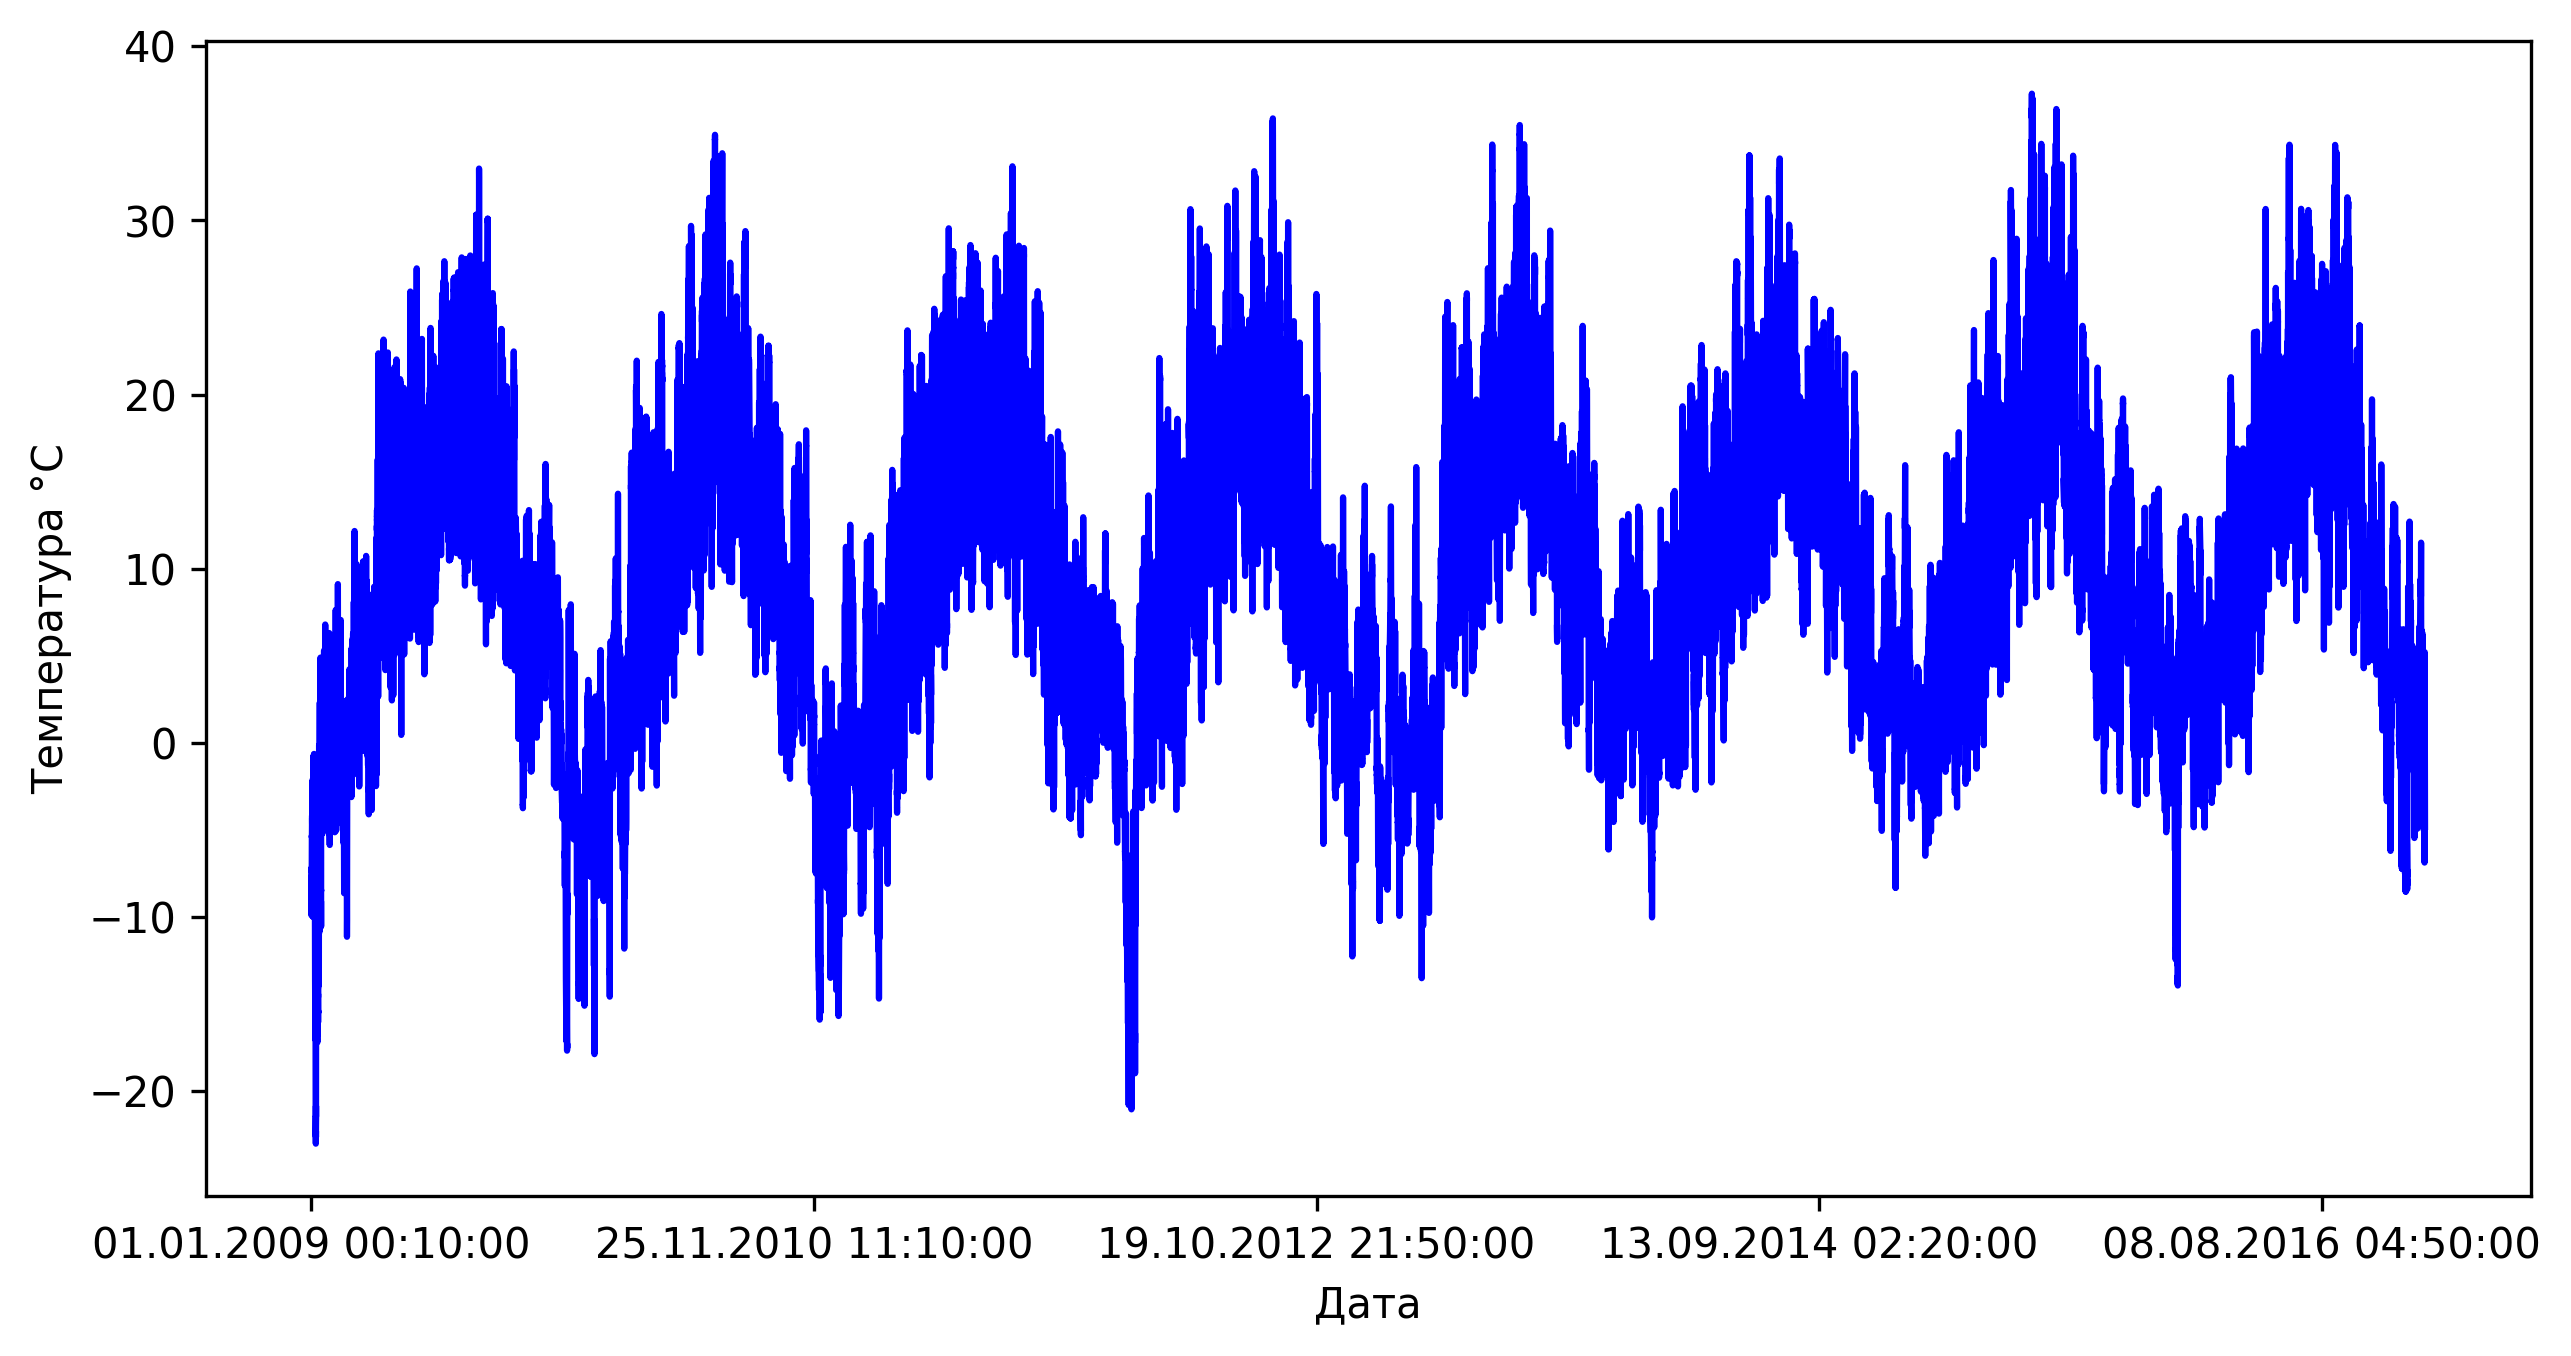

In [3]:
time_data = df["Date Time"]
t_data = df["T (degC)"]
t_data.index = time_data
plt.figure(figsize=(10, 5), dpi=300)
ax = t_data.plot(
    color="blue",
)
plt.xlabel('Дата')
plt.ylabel('Температура °C')
plt.show()

In [4]:
def moving_average(x, n):
    return np.convolve(x, np.ones(n), 'valid') / n

ma_df = moving_average(df["T (degC)"].to_numpy(), n=6)

In [5]:
train_split = int(0.70 * ma_df.shape[0])
val_split = int(0.15 * ma_df.shape[0])

past = 250
future = 50
batch_size = 256
sequence_length = past+future
sampling_rate=6
epochs = 5

In [6]:
features = ma_df
train_data = features[0 : train_split]
val_data = features[train_split:train_split+val_split]
test_data = features[train_split+val_split:]

In [7]:
dataset_train_X = keras.utils.timeseries_dataset_from_array(
    train_data[:-sampling_rate],
    None,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=True,
    seed=1234
)
dataset_train_Y = keras.utils.timeseries_dataset_from_array(
    train_data[sampling_rate:],
    None,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
    shuffle=True,
    seed=1234
)
dataset = tf.data.Dataset.zip((dataset_train_X, dataset_train_Y))
dataset=dataset.shuffle(buffer_size=256)

In [8]:
dataset_val_X = keras.utils.timeseries_dataset_from_array(
    val_data[:-sampling_rate],
    None,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
)
dataset_val_Y = keras.utils.timeseries_dataset_from_array(
    val_data[sampling_rate:],
    None,
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
)
val_dataset = tf.data.Dataset.zip((dataset_val_X, dataset_val_Y))
val_dataset=dataset.shuffle(buffer_size=256)

In [9]:
def causal_attention_mask(batch_size, n_dest, n_src):
    
    i = np.arange(n_dest)[:, None]
    j = np.arange(n_src)
    m = i >= j - n_src + n_dest
    mask = np.cast["bool"](m)
    mask = np.reshape(mask, [1, n_dest, n_src])
    if batch_size is None:
        batch_size=1
    mult = np.concatenate(
        [np.expand_dims(batch_size, -1), np.array([1, 1])], 0
    )
    return np.tile(mask, mult)

In [10]:
class ConvLayersInputs(layers.Layer):
    def __init__(self, num_layers, embed_dim):
        super().__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim

    def call(self, x):
        res = []
        for layer in [layers.Conv1D(self.embed_dim, 3, activation='relu', padding='causal') for _ in range(self.num_layers)]:
            x = layer(x)
            res.append(x)
        return x, res
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "embed_dim": self.embed_dim,
        })
        return config

In [11]:
class ConvLayersOutputs(layers.Layer):
    def __init__(self, num_layers, embed_dim):
        super().__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        

    def call(self, x, res):
        num = 1
        for layer in [layers.Conv1D(self.embed_dim, 3, activation='relu', padding='causal') for _ in range(self.num_layers)]:
            x = layer(x) + res[-num]
            num += 1
        return x
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_layers": self.num_layers,
            "embed_dim": self.embed_dim,
        })
        return config

In [12]:
class PositionEmbedding(layers.Layer):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.pos_emb = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, x):
        positions = np.arange(0, sequence_length, 1)
        positions = self.pos_emb(positions)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
        })
        return config

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate=0.2
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.dropout1 = layers.Dropout(self.rate)
        self.dropout2 = layers.Dropout(self.rate)

    def call(self, inputs):
        input_shape = np.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, sequence_length)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = inputs + attention_output
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        res = out1 + ffn_output
        return res

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
        })
        return config

In [14]:
def create_model(num_conv, num_heads, dim, ff_dim):
    inputs = layers.Input(shape=(sequence_length,1))
    
    embedding_layer = PositionEmbedding(dim)
    x = inputs
    
    res = []
    for layer in [layers.Conv1D(dim, 3, activation='relu', padding='causal') for _ in range(num_conv)]:
        x = layer(x)
        res.append(x)

    x = embedding_layer(x)
    transformer_block = TransformerBlock(dim, num_heads, ff_dim)
    x = transformer_block(x)

    num = 1
    for layer in [layers.Conv1D(dim, 3, activation='relu', padding='causal') for _ in range(num_conv)]:
        x = layer(x) + res[-num]
        num += 1
    
    outputs = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        "adam",
        loss='mse',
        metrics=["mae"]
    )
    return model

In [15]:
model = create_model(12, 4, 64, 64)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 300, 64)      256         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 300, 64)      12352       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 300, 64)      12352       ['conv1d_1[0][0]']               
                                                                                              

In [16]:
checkpoint_filepath = 'checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [17]:
history=model.fit(dataset,validation_data=val_dataset, verbose=1, epochs=15, callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/15
1143/1143 [==============================] - 316s 265ms/step - loss: 1.1594 - mae: 0.5089 - val_loss: 0.2883 - val_mae: 0.3664
Epoch 2/15
1143/1143 [==============================] - 305s 265ms/step - loss: 0.2541 - mae: 0.3498 - val_loss: 0.2184 - val_mae: 0.3292
Epoch 3/15
1143/1143 [==============================] - 308s 268ms/step - loss: 0.1631 - mae: 0.2877 - val_loss: 0.1311 - val_mae: 0.2582
Epoch 4/15
1143/1143 [==============================] - 308s 267ms/step - loss: 0.1188 - mae: 0.2439 - val_loss: 0.1013 - val_mae: 0.2215
Epoch 5/15
1143/1143 [==============================] - 305s 265ms/step - loss: 0.0987 - mae: 0.2180 - val_loss: 0.0813 - val_mae: 0.1932
Epoch 6/15
1143/1143 [==============================] - 304s 264ms/step - loss: 0.0855 - mae: 0.1997 - val_loss: 0.0745 - val_mae: 0.1837
Epoch 7/15
1143/1143 [==============================] - 304s 264ms/step - loss: 0.0747 - mae: 0.1818 - val_loss: 0.0718 - val_mae: 0.1796
Epoch 8/15
1143/1143 [============

In [18]:
model.load_weights("checkpoint.weights.h5")

In [19]:
dataset_test = keras.utils.timeseries_dataset_from_array(
    test_data,
    None,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
)

5

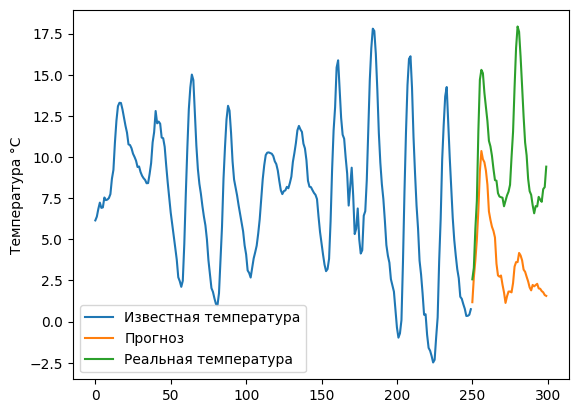

10

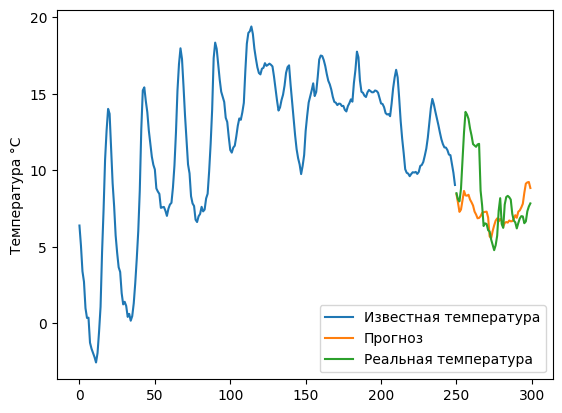

15

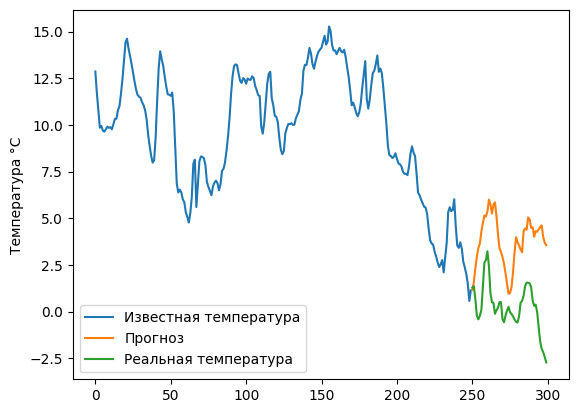

20

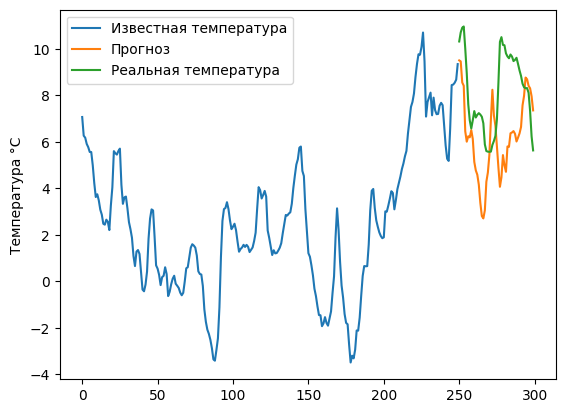

25

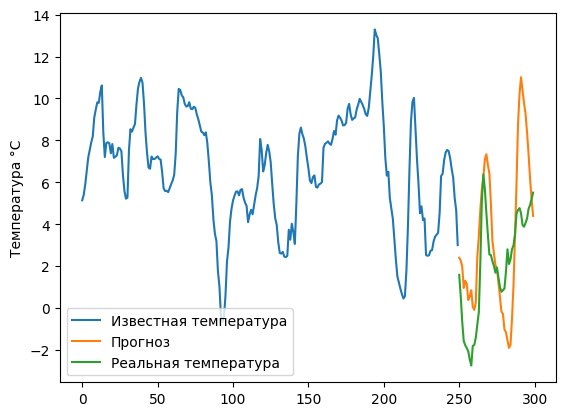

30

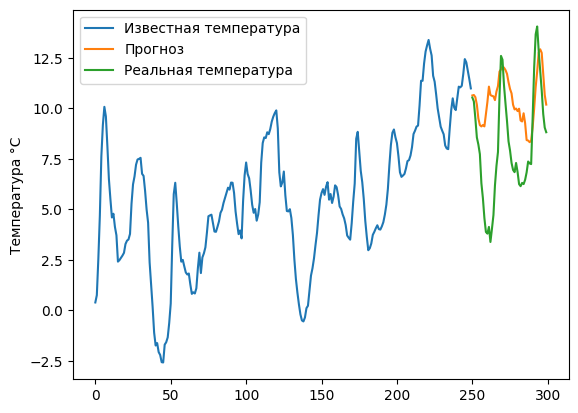

35

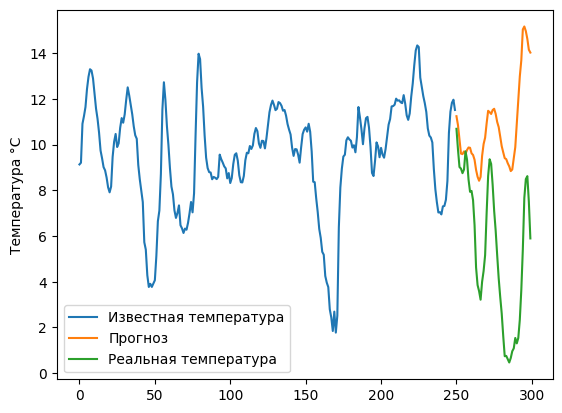

40

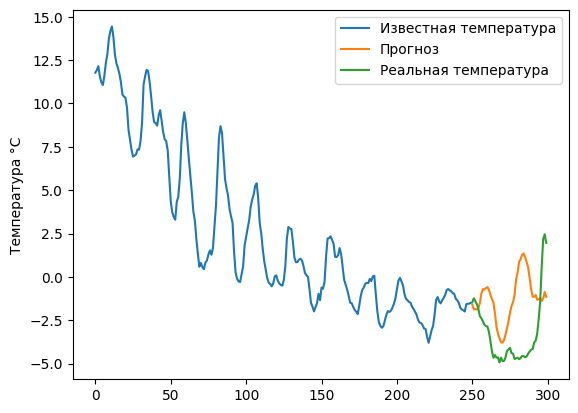

45

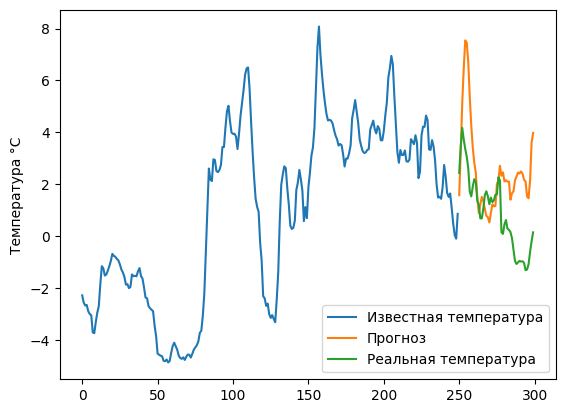

50

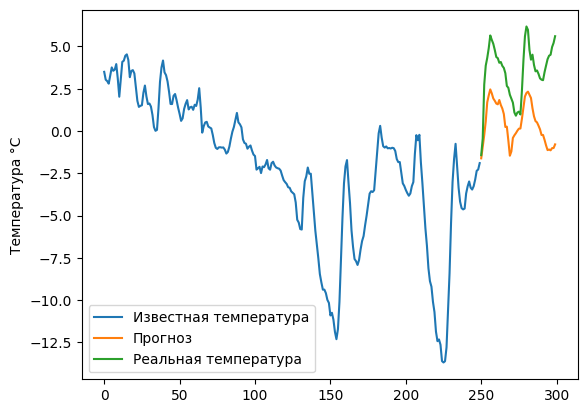

55

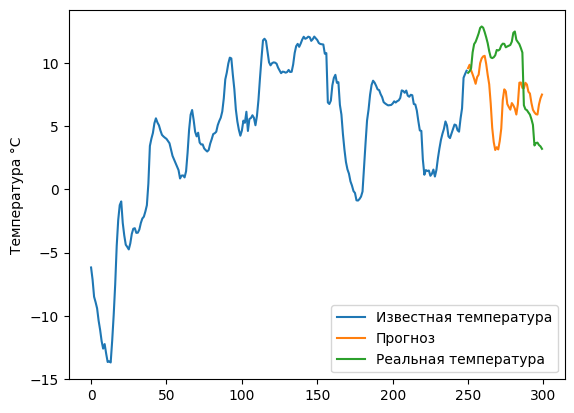

60

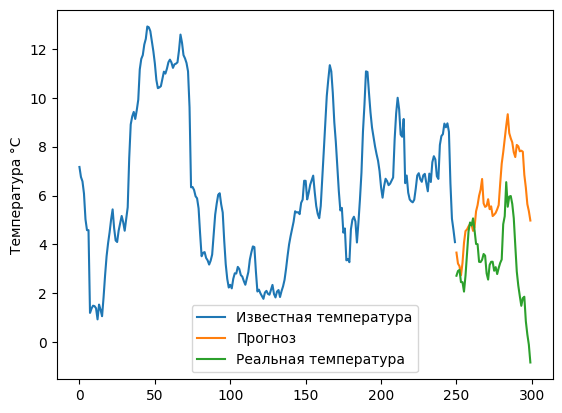

65

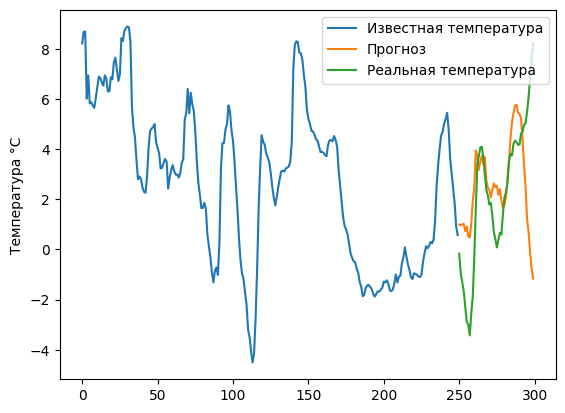

70

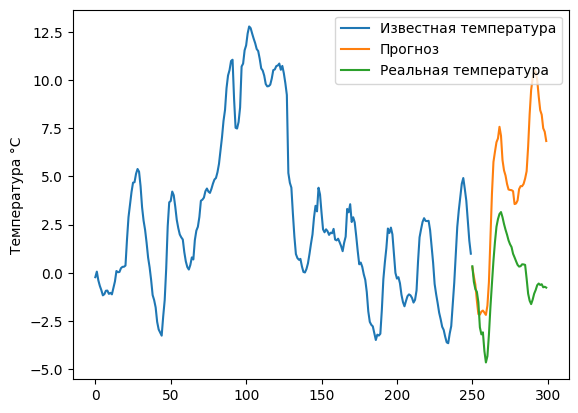

75

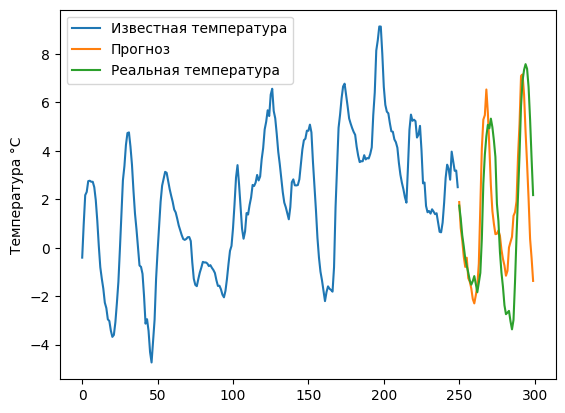

80

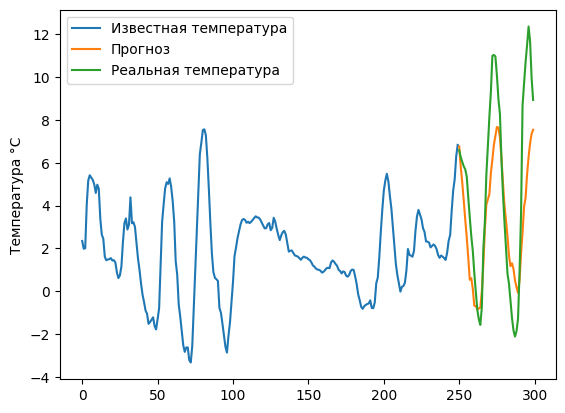

85

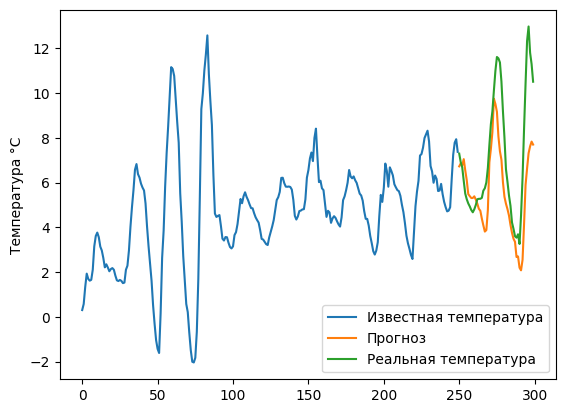

90

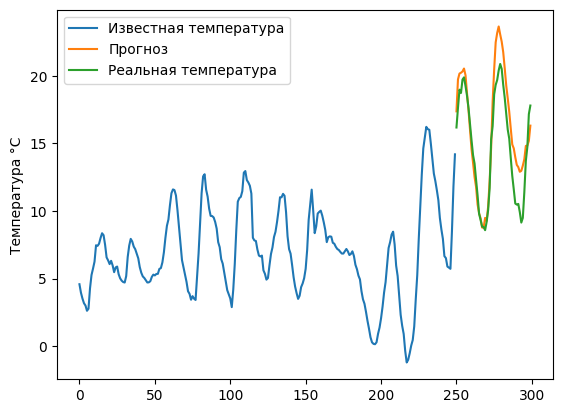

95

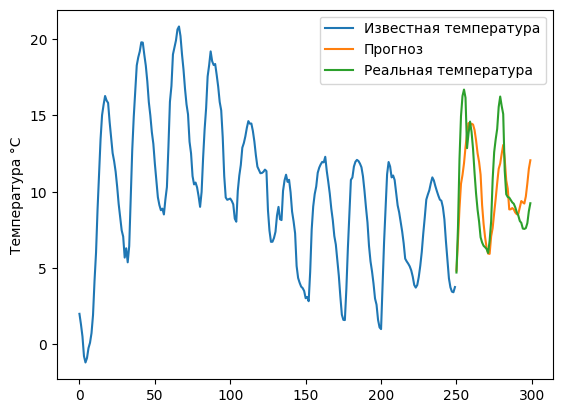

100

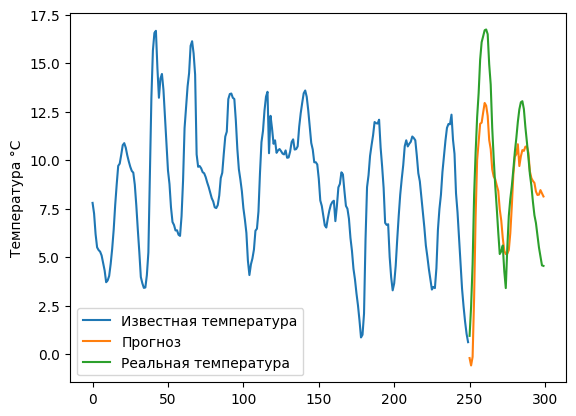

105

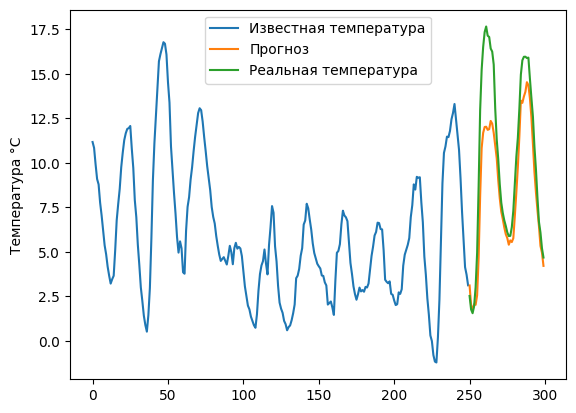

110

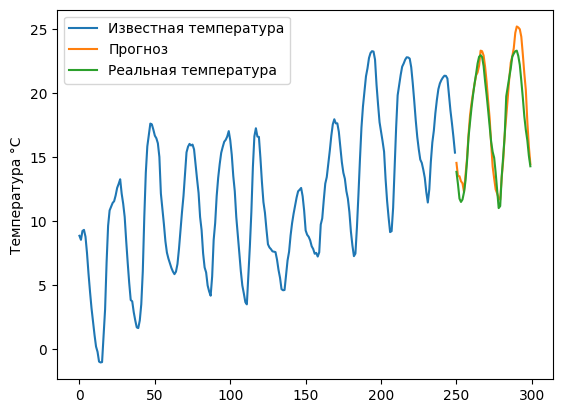

115

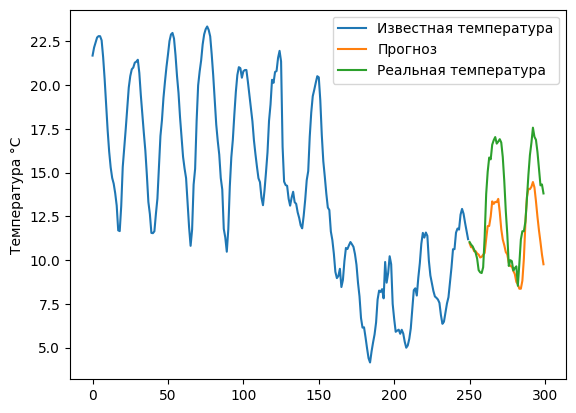

120

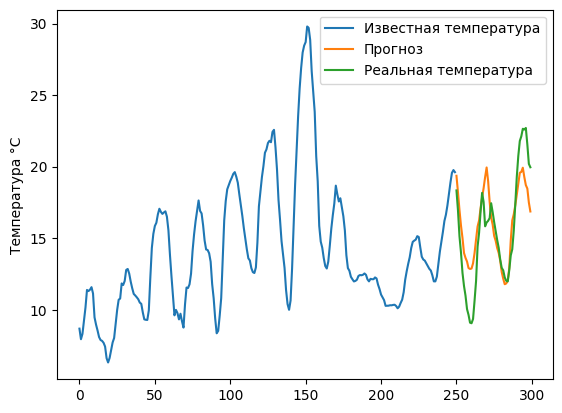

125

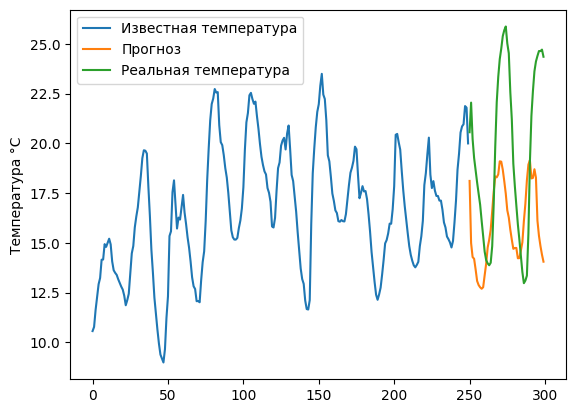

130

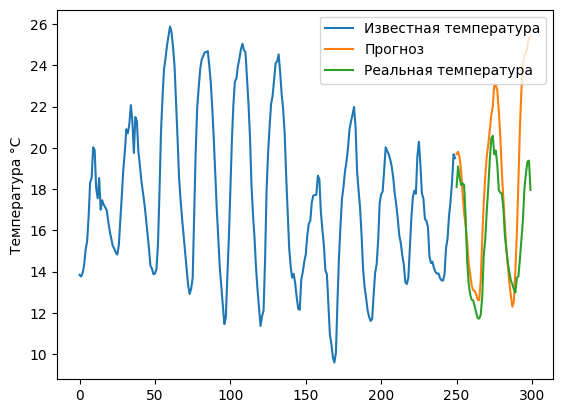

135

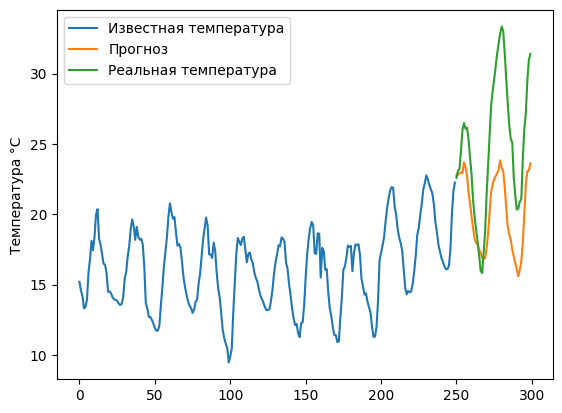

140

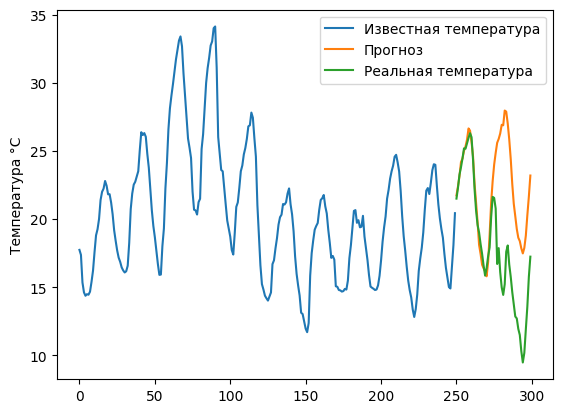

145

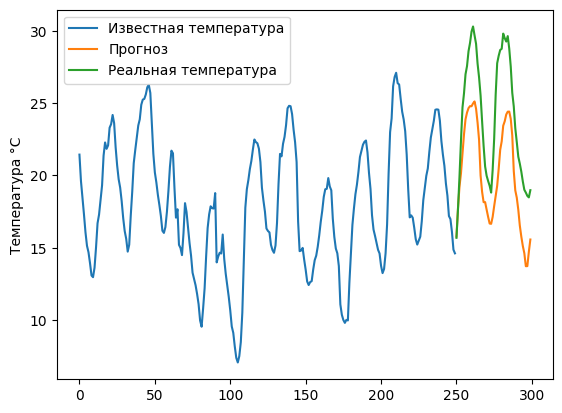

150

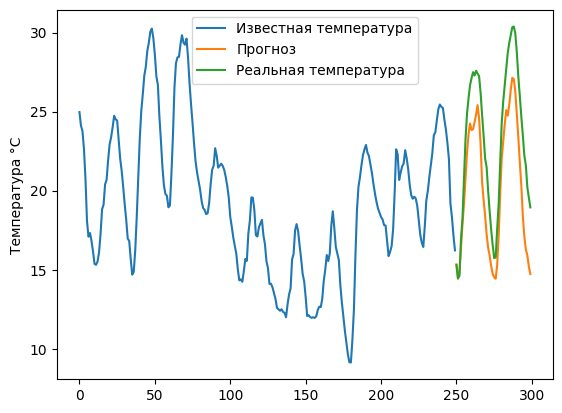

155

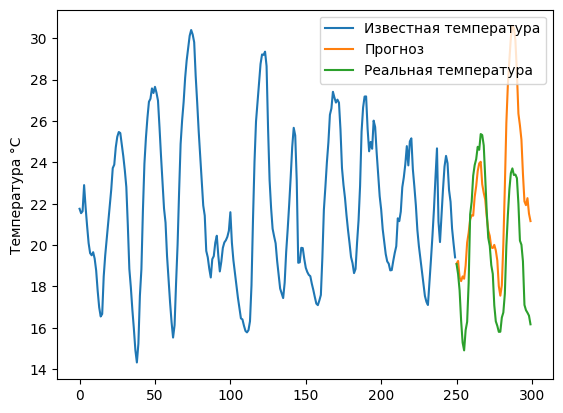

160

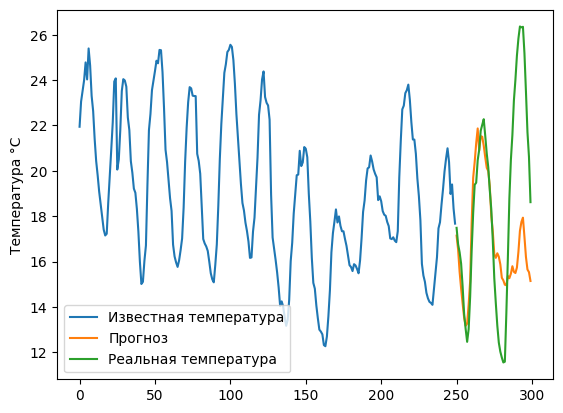

165

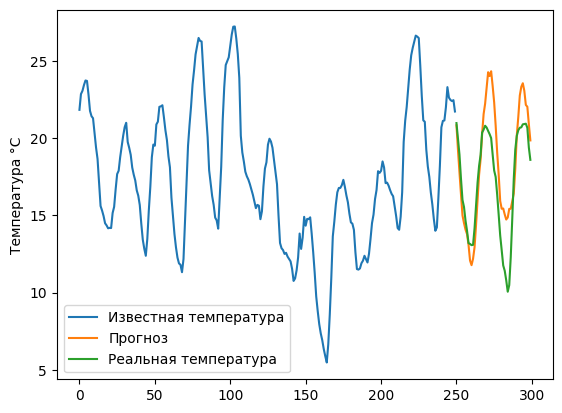

170

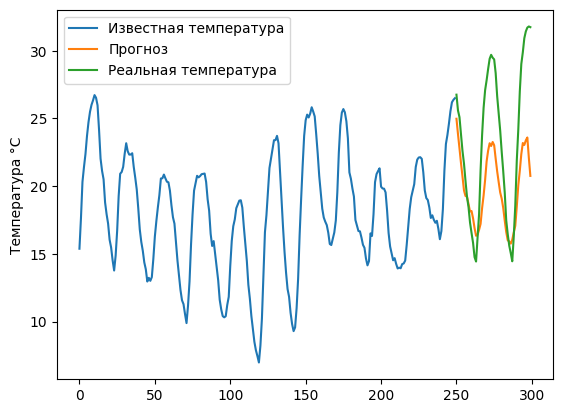

175

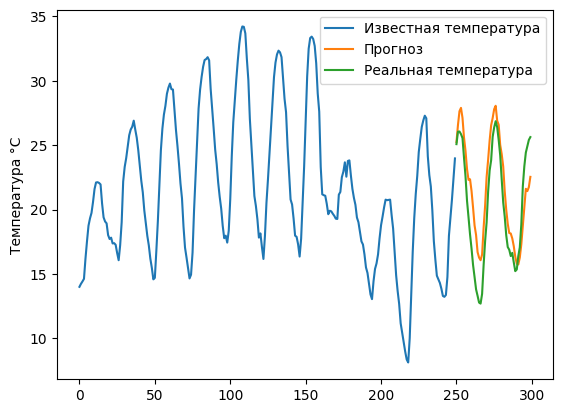

180

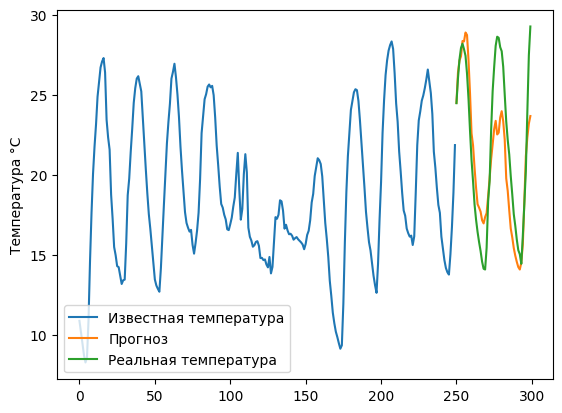

185

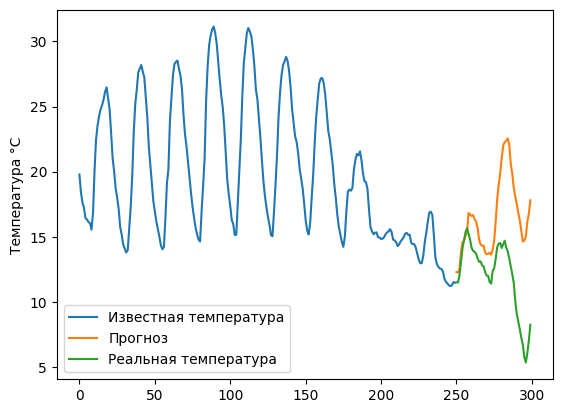

190

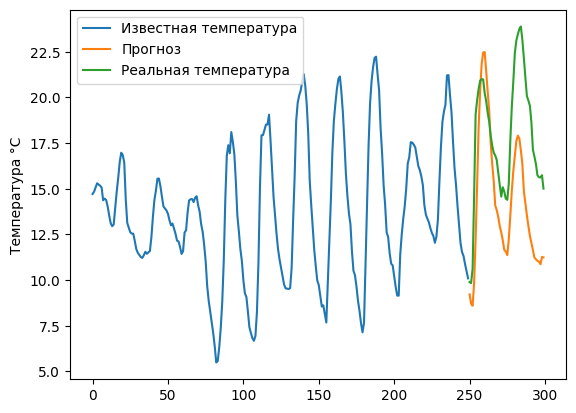

195

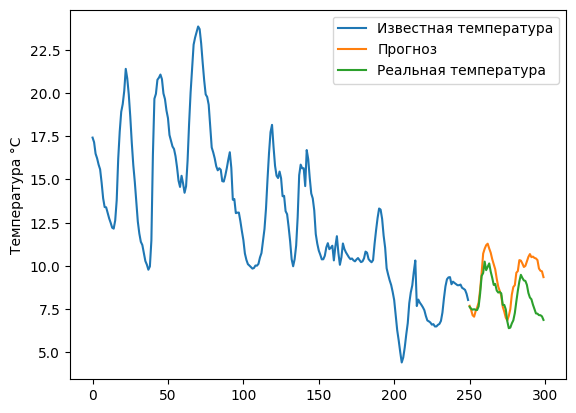

200

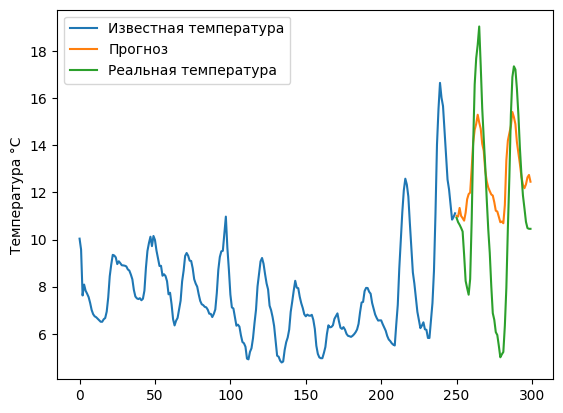

205

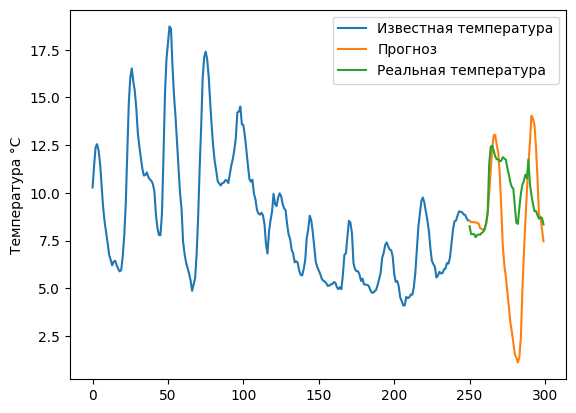

210

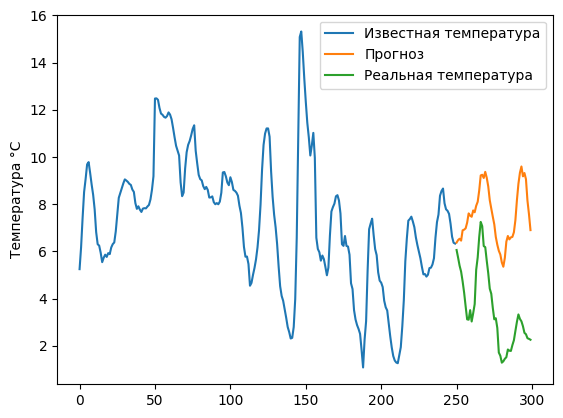

215

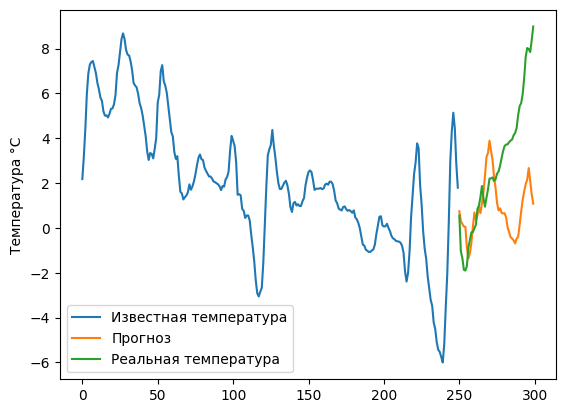

220

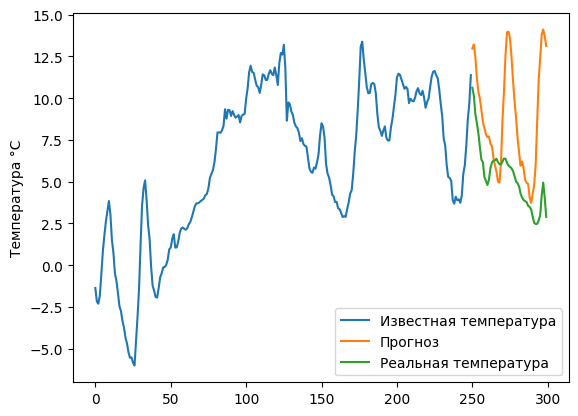

225

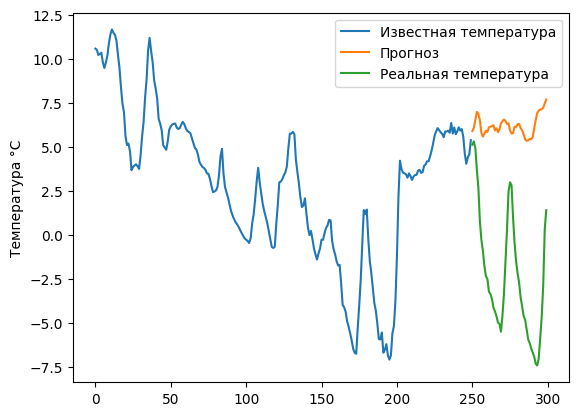

230

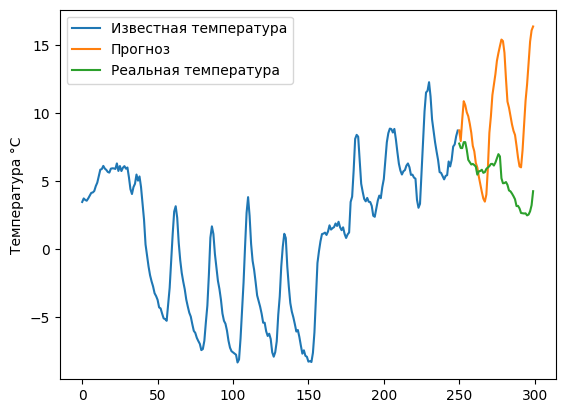

235

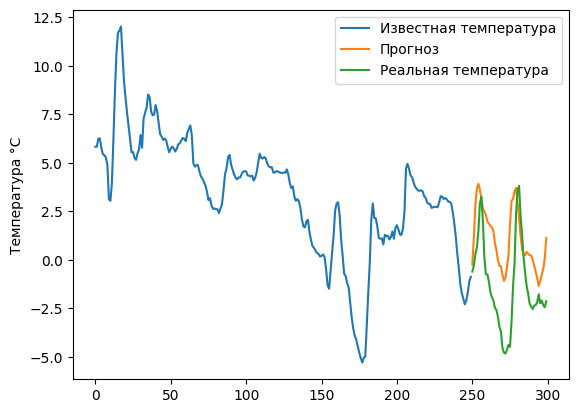

240

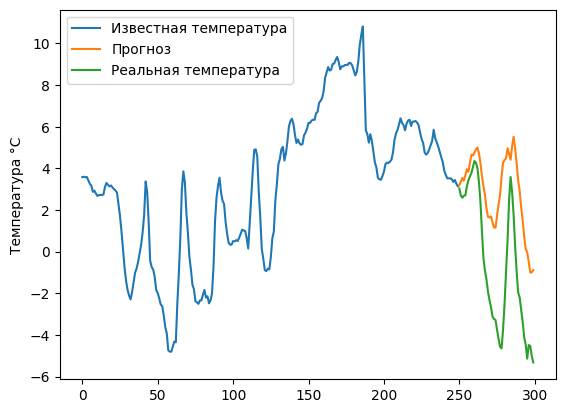

In [20]:
def forecast(model, dataset):

    mse = np.zeros((future,))
    mae = np.zeros((future,))
    num = 0
    
    for inputs in dataset:
        input_data = np.array(inputs[:,:past])
        targets = np.array(inputs[:,past:])
        forecasts = np.zeros(targets.shape)
        num_forecasted = 0 
        while num_forecasted < future:
            x = np.hstack((input_data[:], forecasts))
            y = model.predict(x, verbose=0)
            forecast = y[:,past + num_forecasted - 1]
            forecasts[:,num_forecasted] = forecast[:,0]
            num_forecasted += 1
        
        diff = np.mean(forecasts-targets, axis=0)
        mse += np.square(diff)
        mae += np.abs(diff)
        num += 1
        print(f'\r{num}', end='')
        if num % 5 == 0:
            plt.plot(input_data[0])
            plt.plot(np.arange(past,sequence_length), forecasts[0])
            plt.plot(np.arange(past,sequence_length), targets[0])
            plt.legend(['Известная температура', 'Прогноз', 'Реальная температура'])
            plt.ylabel('Температура °C')
            plt.show()
        
    mse/=num
    mae/=num
    return mse, mae

mse, mae = forecast(model, dataset_test)

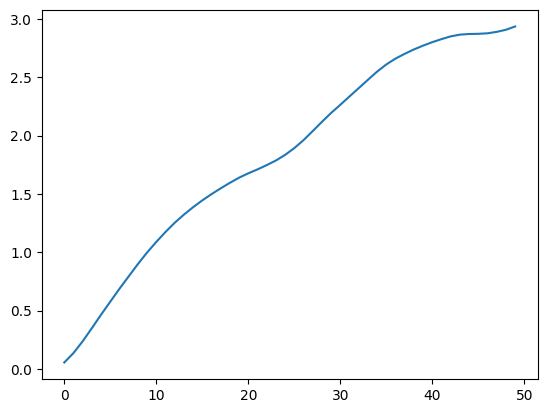

In [21]:
plt.plot(mae)
plt.show()

In [22]:
mae

array([0.05549652, 0.1360679 , 0.23717531, 0.34984434, 0.46532052,
       0.57671767, 0.68754753, 0.79354688, 0.89892899, 0.99799624,
       1.08865768, 1.1738739 , 1.25283612, 1.32265186, 1.38645585,
       1.44474783, 1.49822228, 1.54819989, 1.59524385, 1.63953898,
       1.67678589, 1.71035657, 1.74702329, 1.78664242, 1.83475789,
       1.89284984, 1.96122531, 2.0388128 , 2.11806789, 2.19426975,
       2.26401174, 2.33579804, 2.406698  , 2.47838115, 2.54853707,
       2.60993478, 2.66017185, 2.70116121, 2.73843809, 2.77134917,
       2.80086036, 2.82692087, 2.85059793, 2.865202  , 2.87070547,
       2.87231939, 2.87672171, 2.88912951, 2.90711247, 2.93519327])